In [48]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [49]:
invoice = pd.read_csv('CleanedMergedData.csv')

In [50]:
invoice.shape

(936275, 35)

### Calculating service time in Hrs 

In [51]:
invoice['year'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.year
invoice['month'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.month
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice_DateTime"],dayfirst=True)
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard_DateTime"],dayfirst=True)
invoice['Service_Time'] = invoice['Invoice_DateTime'] - invoice['JobCard_DateTime']
invoice['Service_Time_Hrs'] = invoice['Service_Time']/np.timedelta64(1,'h')
invoice['Service_Time_Hrs'].describe()

count    936275.000000
mean         89.878782
std         275.095915
min          -0.009167
25%           4.048611
50%          23.258889
75%          73.230278
max       17769.261389
Name: Service_Time_Hrs, dtype: float64

In [52]:
invoice[invoice['Service_Time_Hrs']<0]

Unnamed: 0  Unnamed: 0.1 Cust Type Customer No. Gate Pass Time  \
714423      714423        794156    Retail       182085       00:00:00   

        Invoice No  Job Card No  KMs Reading  Labour Total           Make  \
714423  7167000988       363294        62001           0.0  MARUTI SUZUKI   

        Misc Total        Model  OSL Total       Order Type  Parts Total  \
714423         0.0  SWIFT DZIRE        0.0  Running Repairs          0.0   

        Pin code Plant        Plant Name1 Print Status  Recovrbl Exp  \
714423    603103  X085  X085 - SRI MOTORS           NO           0.0   

        Total Amt Wtd Tax.  User ID                           Clean_Location  \
714423                 0.0  X085SA1  Pudupakkam, Padur, Kelambakkam, Thaiyur   

         Clean_City Clean_State    JobCard_DateTime    Invoice_DateTime  \
714423  Kanchipuram  Tamil Nadu 2016-05-02 15:12:44 2016-05-02 15:12:11   

            Service_Time Business Partner  Partner Type Data Origin  \
714423 -1 days +23:59:27              NaN           NaN         NaN   

        DBM Order Item Category  Net value  Order Quantity  year  month  \
714423   363294.0          G2TX        0.0             0.0  2016      5   

        Service_Time_Hrs  
714423         -0.009167

In [53]:
# dropping a row where service time is in negative
invoice.drop(index=714423,axis=0,inplace=True)

In [54]:
invoice.head()

Unnamed: 0  Unnamed: 0.1 Cust Type Customer No. Gate Pass Time  Invoice No  \
0           0             0    Retail        67849       00:00:00  7005200002   
1           1             0    Retail        67849       00:00:00  7005200002   
2           2             0    Retail        67849       00:00:00  7005200002   
3           3             1    Retail        84419       00:00:00  7005200003   
4           4             1    Retail        84419       00:00:00  7005200003   

   Job Card No  KMs Reading  Labour Total            Make  Misc Total   Model  \
0       168303        49317       1203.14  GENERAL MOTORS        0.00   SPARK   
1       168303        49317       1203.14  GENERAL MOTORS        0.00   SPARK   
2       168303        49317       1203.14  GENERAL MOTORS        0.00   SPARK   
3       173997        78584        804.26     TATA MOTORS      197.03  INDICA   
4       173997        78584        804.26     TATA MOTORS      197.03  INDICA   

   OSL Total         Order Type  Parts Total  Pin code Plant Plant Name1  \
0     500.06       Paid Service      2348.75    400601  BC01       THANE   
1     500.06       Paid Service      2348.75    400601  BC01       THANE   
2     500.06       Paid Service      2348.75    400601  BC01       THANE   
3       0.00  SMC Value Package         0.00    400603  BC01       THANE   
4       0.00  SMC Value Package         0.00    400603  BC01       THANE   

  Print Status  Recovrbl Exp  Total Amt Wtd Tax.  User ID  \
0           NO           0.0             4051.95  BC01FS1   
1           NO           0.0             4051.95  BC01FS1   
2           NO           0.0             4051.95  BC01FS1   
3           NO           0.0             1001.29  BC01SA2   
4           NO           0.0             1001.29  BC01SA2   

                       Clean_Location Clean_City  Clean_State  \
0  Thane Bazar, Thane H.O, Thane R.S.      Thane  Maharashtra   
1  Thane Bazar, Thane H.O, Thane R.S.      Thane  Maharashtra   
2  Thane Bazar, Thane H.O, Thane R.S.      Thane  Maharashtra   
3            Thane East, Kopri Colony      Thane  Maharashtra   
4            Thane East, Kopri Colony      Thane  Maharashtra   

     JobCard_DateTime    Invoice_DateTime     Service_Time Business Partner  \
0 2014-12-13 14:29:43 2015-01-02 11:30:36 19 days 21:00:53              NaN   
1 2014-12-13 14:29:43 2015-01-02 11:30:36 19 days 21:00:53              NaN   
2 2014-12-13 14:29:43 2015-01-02 11:30:36 19 days 21:00:53              NaN   
3 2015-01-02 14:12:18 2015-01-03 10:07:32  0 days 19:55:14              NaN   
4 2015-01-02 14:12:18 2015-01-03 10:07:32  0 days 19:55:14              NaN   

   Partner Type Data Origin  DBM Order Item Category  Net value  \
0           NaN         NaN   168303.0          P001    1203.14   
1           NaN         NaN   168303.0          P002    2348.75   
2           NaN         NaN   168303.0          P010     500.06   
3           NaN         NaN   173997.0          P001     804.26   
4           NaN         NaN   173997.0          P011     197.03   

   Order Quantity  year  month  Service_Time_Hrs  
0            73.0  2015      1        477.014722  
1             6.5  2015      1        477.014722  
2             1.0  2015      1        477.014722  
3           170.0  2015      1         19.920556  
4             1.0  2015      1         19.920556

### Calculation of Life Time Value for each customer over a period of 2016 (1 year) based on "Make" and "Model" of the cars

In [55]:
invoice_16=invoice[invoice["year"]==2016]

In [56]:
invoice_16.shape

(337170, 38)

In [57]:
invoice_16.head()

Unnamed: 0  Unnamed: 0.1 Cust Type Customer No. Gate Pass Time  \
599104      599104        730169    Retail       119371       15:41:33   
599105      599105        730169    Retail       119371       15:41:33   
599106      599106        730169    Retail       119371       15:41:33   
599107      599107        730170    Retail       128929       13:05:33   
599108      599108        730170    Retail       128929       13:05:33   

        Invoice No  Job Card No  KMs Reading  Labour Total           Make  \
599104  7005202789       300412        35654       1125.76  MARUTI SUZUKI   
599105  7005202789       300412        35654       1125.76  MARUTI SUZUKI   
599106  7005202789       300412        35654       1125.76  MARUTI SUZUKI   
599107  7005202790       300447        70730        233.85  MARUTI SUZUKI   
599108  7005202790       300447        70730        233.85  MARUTI SUZUKI   

        Misc Total       Model  OSL Total         Order Type  Parts Total  \
599104      291.45  ZEN ESTILO        0.0  SMC Value Package      2082.07   
599105      291.45  ZEN ESTILO        0.0  SMC Value Package      2082.07   
599106      291.45  ZEN ESTILO        0.0  SMC Value Package      2082.07   
599107        0.00       SWIFT        0.0    Running Repairs       195.44   
599108        0.00       SWIFT        0.0    Running Repairs       195.44   

        Pin code Plant Plant Name1 Print Status  Recovrbl Exp  \
599104    400089  BC01       THANE          YES           0.0   
599105    400089  BC01       THANE          YES           0.0   
599106    400089  BC01       THANE          YES           0.0   
599107    400604  BC01       THANE          YES           0.0   
599108    400604  BC01       THANE          YES           0.0   

        Total Amt Wtd Tax.  User ID                    Clean_Location  \
599104             3499.28  BC01SA2  Tilak Nagar (Mumbai), Chembur Rs   
599105             3499.28  BC01SA2  Tilak Nagar (Mumbai), Chembur Rs   
599106             3499.28  BC01SA2  Tilak Nagar (Mumbai), Chembur Rs   
599107              429.29  BC01SA2                        Wagle I.E.   
599108              429.29  BC01SA2                        Wagle I.E.   

       Clean_City  Clean_State    JobCard_DateTime    Invoice_DateTime  \
599104     Mumbai  Maharashtra 2016-01-02 10:52:24 2016-01-02 11:27:27   
599105     Mumbai  Maharashtra 2016-01-02 10:52:24 2016-01-02 11:27:27   
599106     Mumbai  Maharashtra 2016-01-02 10:52:24 2016-01-02 11:27:27   
599107      Thane  Maharashtra 2016-01-02 11:50:58 2016-01-02 13:03:16   
599108      Thane  Maharashtra 2016-01-02 11:50:58 2016-01-02 13:03:16   

       Service_Time Business Partner  Partner Type Data Origin  DBM Order  \
599104     00:35:03              NaN           NaN         NaN   300412.0   
599105     00:35:03              NaN           NaN         NaN   300412.0   
599106     00:35:03              NaN           NaN         NaN   300412.0   
599107     01:12:18              NaN           NaN         NaN   300447.0   
599108     01:12:18              NaN           NaN         NaN   300447.0   

       Item Category  Net value  Order Quantity  year  month  Service_Time_Hrs  
599104          P001    1125.76             2.0  2016      1          0.584167  
599105          P002    2082.07            10.0  2016      1          0.584167  
599106          P011     291.45             1.0  2016      1          0.584167  
599107          P001     233.85            36.0  2016      1          1.205000  
599108          P002     195.44             1.0  2016      1          1.205000

In [58]:
# Calculating frequency of visits & total revenue of a customer for calculation of lifetime value

customer_freq=invoice_16.groupby(["Make","Model","Clean_Location","Customer No."]).agg({"Invoice No":'nunique',"Total Amt Wtd Tax.":'mean',"Service_Time_Hrs":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head()

ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r["Invoice No"] * ltv_make_model_r["Total Amt Wtd Tax."]
ltv_make_model_r.head()

Make Model                                     Clean_Location Customer No.  \
0  AUDI    A4  Athwa, Magdalla, Umra, Khajod, Abhva, Bharthan...       188266   
1  AUDI    A4  Athwa, Magdalla, Umra, Khajod, Abhva, Bharthan...       195278   
2  AUDI    A4                                     Bhayander East       152743   
3  AUDI    A4  Haldi, Ghanavade, Sadoli Khalsa, Bachani, Are,...        83636   
4  AUDI    A4  Indore G.P.O., Indore CGO Complex, Indore Taks...       158521   

   Invoice No  Total Amt Wtd Tax.  Service_Time_Hrs       LTV  
0           1              554.52          3.029444    554.52  
1           1              554.74          2.096667    554.74  
2           1              750.25          0.140278    750.25  
3           2             1125.25         11.002361   2250.50  
4           3            23460.48         31.365926  70381.44

### Filtering customer having LTV/Total revenue > 0 

In [59]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [60]:
ltv_make_model_r.shape

(114292, 8)

### Quantile based analysis of LTV to decide threshold

In [61]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 99.14
0.25 quantile :- 450.5
0.50 quantile :- 2281.699285714286
0.75 quantile :- 6664.26
0.95 quantile :- 29288.20094444444
minimum LTV :- 0.01
maximum LTV :- 1790743.6553142855
mean LTV :- 7296.1905744182295


In [62]:
print(ltv_make_model_r[ltv_make_model_r["LTV"]<=2281.69].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV"]>2281.69)&(ltv_make_model_r["LTV"]<=6664.26)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV"]>6664.26].shape)

(57146, 8)
(28573, 8)
(28573, 8)


In [63]:
bins=[-1,2281.69,6664.26,1790743.6553142855]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV"], bins=bins, labels=labels)

In [64]:
ltv_make_model_r["LTV Binned"].value_counts(dropna=False)

Low       57146
High      28573
Medium    28573
Name: LTV Binned, dtype: int64

In [65]:
ltv_make_model_r.dropna(inplace=True)

In [66]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [67]:
le=LabelEncoder()
temp_ltv_make_model_r["Make"]=le.fit_transform(temp_ltv_make_model_r["Make"])
temp_ltv_make_model_r["Model"]=le.fit_transform(temp_ltv_make_model_r["Model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["Clean_Location"]=le.fit_transform(temp_ltv_make_model_r["Clean_Location"])

In [68]:
temp_ltv_make_model_r.head()

Make  Model  Clean_Location Customer No.  Invoice No  Total Amt Wtd Tax.  \
0     0      8             292       188266           1              554.52   
1     0      8             292       195278           1              554.74   
2     0      8             603       152743           1              750.25   
3     0      8            1511        83636           2             1125.25   
4     0      8            1663       158521           3            23460.48   

   Service_Time_Hrs       LTV  LTV Binned  
0          3.029444    554.52           1  
1          2.096667    554.74           1  
2          0.140278    750.25           1  
3         11.002361   2250.50           1  
4         31.365926  70381.44           0

In [69]:
X=temp_ltv_make_model_r.drop(["Customer No.","LTV","LTV Binned","Invoice No"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [70]:
list(X)

['Make', 'Model', 'Clean_Location', 'Total Amt Wtd Tax.', 'Service_Time_Hrs']

In [71]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

### Decision Tree Classifier

In [72]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      8614
           1       0.90      1.00      0.95     17060
           2       0.75      0.80      0.78      8614

    accuracy                           0.88     34288
   macro avg       0.88      0.84      0.85     34288
weighted avg       0.89      0.88      0.87     34288



In [73]:
print("Training Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("Testing Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8770415305646291
Testing Accuracy :- 0.8824558772061397


<BarContainer object of 5 artists>

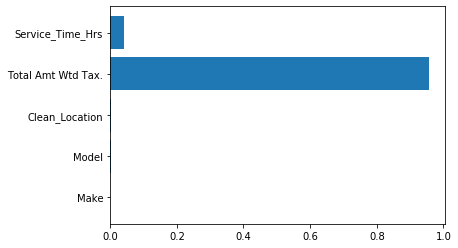

In [74]:
plt.barh(list(X),list(dt.feature_importances_))

In [75]:
### Cross Validation Score

dt_cv_score=cross_val_score(estimator=dt,X=X,y=y,cv=5)

print(dt_cv_score.mean())

0.8579686615682529


### Random Forest Classifier

In [76]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)

In [77]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [78]:
y_pred_rfc=rfc.predict(X_test)

In [79]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      8614
           1       0.90      1.00      0.95     17060
           2       0.74      0.80      0.77      8614

    accuracy                           0.87     34288
   macro avg       0.88      0.83      0.85     34288
weighted avg       0.88      0.87      0.87     34288



In [80]:
accuracy_score(y_test,y_pred_rfc)

0.8746791880541297

In [81]:
plt.barh(list(X),list(rfc.feature_importances_))

<BarContainer object of 5 artists>

In [82]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [83]:
score.mean()

0.8431557200720639

### XgBoost Classifier

In [84]:
xgb=XGBClassifier()

In [85]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
y_pred_xgb=xgb.predict(X_test)

In [87]:
accuracy_score(y_test,y_pred_xgb)

0.8915655622958469

In [88]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      8614
           1       0.92      0.99      0.95     17060
           2       0.78      0.81      0.80      8614

    accuracy                           0.89     34288
   macro avg       0.89      0.86      0.87     34288
weighted avg       0.89      0.89      0.89     34288



In [89]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)

In [90]:
scores_xgb.mean()

0.8270739578771986